# Credit Card Fraud

Quels facteurs sur les transactions bancaires nous permettent de prédire une fraude à la carte bancaire ?

- EDA
- Preprocessing (ACP, feature selection)
- Modèles :
-* ML supervisé de classification binaire avec régression logistique, RandomForest, (régression linéaire pour les montants) ;
-* ML non supervisé avec clustering géographique DBScan Elbow+Silhouette
- Confrontation des résultats (quel serait le meilleur modèle pour prédire la fraude)
- Exemple de prédiction
- Mise en place du dashboard
- Proposer des questions d'ouverture (pour la présentation)

Si on a le temps : prédire le montant de la fraude (régression linéaire)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
data = pd.read_csv('src/fraud test.csv')
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


#### Cleansing

In [3]:
def data_cleanse(data_sample):
    '''On retire les colonnes qui ne sont pas pertinentes
        cc_num, trans_num, first, last et {city, state, street, zip} = infos individuelles trop de valeurs différentes
        merchant = idem
        Unnamed: 0 = index, des identifiants donc à supprimer
        unix_time = temps Unix, redondant'''
    colonne_a_retirer = ['cc_num', 'first', 'last', 'city', 'state', 'street', 'zip', 'trans_num', 'Unnamed: 0', 'merchant', 'unix_time', 'lat', 'long']
    df = data_sample.drop(colonne_a_retirer, axis=1)
    df["trans_date_trans_time"]=pd.to_datetime(df["trans_date_trans_time"], format= "%d/%m/%Y %H:%M")
    df["dob"]=pd.to_datetime(df["dob"], format= "%d/%m/%Y")

    annee_actuelle = pd.Timestamp.now().year
    df['age'] = annee_actuelle - df["dob"].dt.year

    df["day_of_the_week"]=df["trans_date_trans_time"].dt.weekday
    df["month"]=df["trans_date_trans_time"].dt.month
    df["day"]=df["trans_date_trans_time"].dt.day
    df["year"]=df["trans_date_trans_time"].dt.year
    df["hour"]=df["trans_date_trans_time"].dt.hour

    colonne_a_retirer = ['trans_date_trans_time', 'dob']
    df = df.drop(colonne_a_retirer, axis=1)
    return df

#### Sample

In [4]:
data_sample = data.sample(frac=0.5, random_state=0)
df = data_cleanse(data_sample)

### Model selection evaluation

#### Preprocessings

On reprend les preprocessings du baseline model

- Corriger : prendre un sample plus grand mais avec les mêmes proportions (frac = 0.5)
- Puis data cleanse
- Puis train test split
- Undersampling sur le train uniquement
- Fit Random Forest

In [5]:
categorical_features = ['category', 'gender']
numerical_features = ['age', 'day', 'month', 'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long']
features = categorical_features + numerical_features
target = 'is_fraud'

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop="first"))]
)

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer([
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

X = df.loc[:,features]
y = df.loc[:,target]

In [6]:
X_trainval, X_test_0, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

rus = RandomUnderSampler(random_state=42, replacement=True) # fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X_trainval, y_trainval)

X_train_0, X_val_0, y_train, y_val = train_test_split(X_rus, y_rus, train_size=0.7/0.85, random_state=0, stratify=y_rus)

X_train = preprocessor.fit_transform(X_train_0)
X_val = preprocessor.transform(X_val_0)
X_test = preprocessor.transform(X_test_0)

In [7]:
print('Original dataset shape:', y_trainval.shape)
print('Resample dataset shape', y_rus.shape)

Original dataset shape: (236181,)
Resample dataset shape (1868,)


In [8]:
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    "max_depth": [15],
    "min_samples_leaf": [5],
    "min_samples_split": [16],
    "n_estimators": [50],
}
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=5,
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 16, 'n_estimators': 50}
Best validation score :  0.7464338593003087


In [9]:
y_train_pred = gridsearch.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       769
           1       0.88      0.89      0.89       769

    accuracy                           0.88      1538
   macro avg       0.88      0.88      0.88      1538
weighted avg       0.88      0.88      0.88      1538



In [12]:
y_val_pred = gridsearch.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       165
           1       0.78      0.75      0.76       165

    accuracy                           0.77       330
   macro avg       0.77      0.77      0.77       330
weighted avg       0.77      0.77      0.77       330



In [10]:
y_test_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.87     41514
           1       0.01      0.73      0.03       165

    accuracy                           0.78     41679
   macro avg       0.51      0.75      0.45     41679
weighted avg       0.99      0.78      0.87     41679



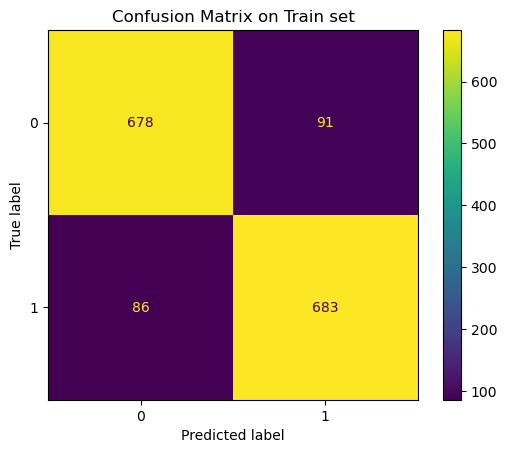

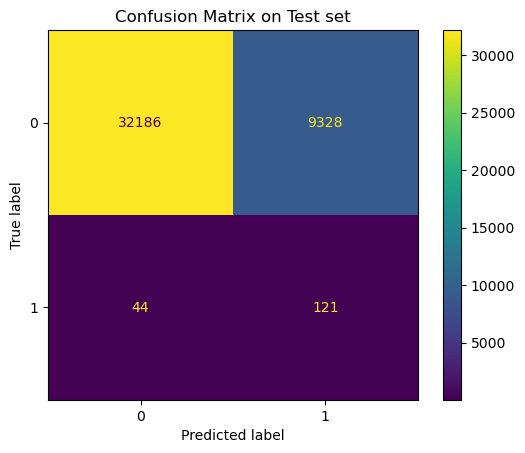

In [11]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

#### Random Forest (avec SMOTE)

In [6]:
# Sample en conservant la proportion de is_fraud=0 et de is_fraud=1
data_sample_unbalanced = data.sample(frac=0.1, random_state=0)
print(data_sample_unbalanced['is_fraud'].value_counts())

df = data_cleanse(data_sample_unbalanced)

is_fraud
0    55359
1      213
Name: count, dtype: int64


In [7]:
categorical_features = ['category', 'gender']
numerical_features = ['age', 'day', 'month', 'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long']
features = categorical_features + numerical_features
target = 'is_fraud'

In [9]:
X = df.loc[:,features]
y = df.loc[:,target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#smote = SMOTE()
smotenc = SMOTENC(categorical_features=[0, 1])

X_smote, y_smote = smotenc.fit_resample(X_train, y_train)

categorical_transformer = OneHotEncoder(drop="first")
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [11]:
X_train = preprocessor.fit_transform(X_smote)
X_test = preprocessor.transform(X_test)
y_train = y_smote

In [12]:
dict_weights = {0: 1, 1: 10}

In [13]:
print("Grid search...")
classifier = RandomForestClassifier(class_weight=dict_weights)

# Grid of values to be tested
params = {
    "max_depth": [2, 5, 10, 15],
    "min_samples_leaf": [2, 5, 8],
    "min_samples_split": [2, 4, 8, 16],
    "n_estimators": [50],
}
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=5, scoring='f1'
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation score : ", gridsearch.best_score_)

Grid search...


KeyboardInterrupt: 

In [105]:
y_train_pred = gridsearch.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.19      0.32     44287
           1       0.55      1.00      0.71     44287

    accuracy                           0.60     88574
   macro avg       0.78      0.60      0.52     88574
weighted avg       0.78      0.60      0.52     88574



In [106]:
y_test_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33     11072
           1       0.00      0.93      0.01        43

    accuracy                           0.20     11115
   macro avg       0.50      0.56      0.17     11115
weighted avg       0.99      0.20      0.33     11115



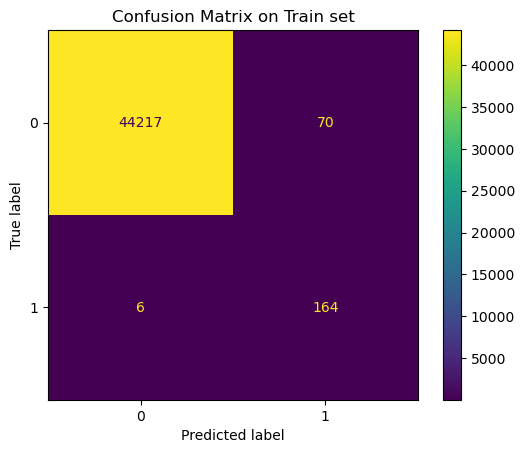

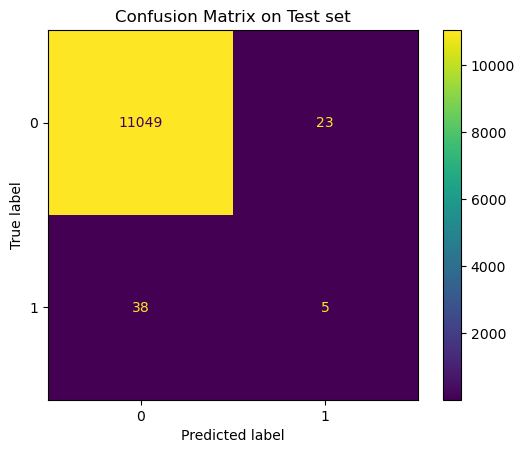

In [85]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()